# Notebook 3 - Plots and analysis

***

In this notebook we will showcase most of the functions that will be useful for analysis of steering: 
1. [Ranking Shifts](#ranking-shifts)
2. [Convergence Check](#convergence-check)
3. [Neuron Activations for Categories](#neuron-activations-for-categories)
4. [Neuron Activations for Tokens and Texts](#neuron-activations-for-tokens-and-texts)

In [1]:
# Append the path to the Functions directory

import sys
sys.path.append('../Functions')
sys.path.append('../Features')

## Functions used in this notebook:
### From "Ranking_shifts.py":
- [calculate_specific_differences](#calculate-specific-differences) - Calculate distance differences between original and steered embeddings
- [title_ranking_difference](#title-ranking-difference) - Compare top movie rankings before and after steering
- [rank_categories_by_difference](#rank-categories-by-difference) - Rank movie categories by mean steering effects
- [get_most_shifted_categories](#get-most-shifted-categories) - Identify categories most affected by steering
- [experimentation_function](#experimentation-function) - Export category shifts for single node steering for a layer
- [plot_change_in_top_shift](#plot-change-in-top-shift) - Plot category changes across steering coefficients
- [plot_rank_plot](#plot-rank-plot) - Visualize category ranking shifts

### From "Convergence_check.py":
- [convergence_check_with_vector](#steering-with-a-vector) - Plots the mean of the distance between the steered embeddings and the steering vector for a range of coefficients
- [convergence_check_with_neuron](#steering-with-a-neuron) - plots the mean of the distance between the steered embeddings and a comparison vector (feature embedding) for a range of coefficients.
- [convergence_by_category](#convergence-by-category) - plots the mean distances from the steered embeddings to the steering vector, for each of the categories given

### From "Activations_tokens_and_texts.py".
- [get_text_activations_per_layer](#get-text-activations) - Calculates the activations for all neurons in a layer
- [plot_text_activations_per_layer](#plot-text-activations) - Plots the activation values and neuron index for all neurons in a layer
- [compare_text_activations](#compare-text-activations) - Plots two differet texts' activations for comparison
- [find_extreme_nodes_for_all_texts](#find-extreme-nodes) - Finds the most and least activated neurons for the texts
- [plot_extreme_nodes_for_all_texts](#plot-extreme-nodes) - Plots the most and least activated neurons for the texts (text_index, neuron_index)

### From "Activations_categories.py":
- [get_category_activations](#get-category-activations) - Extract neuron activations for a category in a layer
- [plot_category_activations](#plot-category-activations) - Plot the activations
- [find_activation_shift](#find-activation-shift) - Find the most shifted neurons before vs. after steering
- [create_neuron_shift_heatmap](#create-heatmap) - Create a heatmap of the most shifted neurons across categories
- [plot_change_in_top_shifted_neurons](#plot-change-in-top-shifted-neurons) - Plot how most shifted / activated neurons are steered with varying coefficient

### Other functions
- "Embeddings.py": import_embedding_data_from_pkl - Loads embeddings and model data from file
- "Steering_vector.py": import_steering_vector_from_pkl - Loads steering vector from file
- "Steering.py": get_steered_embeddings_vector - Applies steering using a steering vector and returns the steered embeddings

## Import Python Functions

In [2]:
# Import needed functions
from Embeddings import import_embedding_data_from_pkl
from Steering_vector import import_steering_vector_from_pkl
from Steering import get_steered_embeddings_vector, create_steered_model_output

In [3]:
from Ranking_shifts import calculate_specific_differences, title_ranking_difference, rank_categories_by_difference, get_most_shifted_categories, experimentation_function, plot_change_in_top_shift, plot_rank_plot
from Convergence_check import convergence_check_with_vector, convergence_check_with_neuron, convergence_by_category
from Activations_categories import get_category_activations, plot_category_activations, find_activation_shift, create_neuron_shift_heatmap, plot_change_in_top_shifted_neurons
from Activations_tokens_and_texts import get_text_activations_per_layer, plot_text_activations_per_layer, compare_text_activations, find_extreme_nodes_for_all_texts, plot_extreme_nodes_for_all_texts


***

# Ranking Shifts

The following functions are imported from the file `"Ranking_shifts.py"`. They are used to create a number of outputs that can be used to analyze the effect of steering on the dataset.


In [4]:
#from Ranking_shifts import calculate_specific_differences, title_ranking_difference, rank_categories_by_difference, get_most_shifted_categories, experimentation_function, plot_change_in_top_shift, plot_rank_plot

## Setup

Before we start analyzing we need to import the embedding data we created in `Notebook 1`, as well as a steering vector.

In [5]:
# Import the necessasry data
data = import_embedding_data_from_pkl('Test_export_embeddings.pkl', model=True, embeddings=True, encoded_input=True, all_texts_data=True)
model, original_embeddings, encoded_input, all_texts_data = data

feature = "War"
type = "cosine" # Chose what distance measure to use: l1, l2 or cosine
layer_to_steer = 11  # Change this to the layer you want to analyze
steering_coefficient = 1  # Adjust steering coefficient as needed

steering_vector = import_steering_vector_from_pkl('steering_vector.pkl', feature_name=feature, layer_to_steer=layer_to_steer)

# We will now create the steered embeddings. For demonstration purposes, we will steer using our steering vector and the l2 distance measure.
steered_embeddings = get_steered_embeddings_vector(
    model, 
    encoded_input, 
    layer_to_steer=layer_to_steer, 
    steering_coefficient=steering_coefficient, 
    steering_vector=steering_vector, 
    normalize=True
    )

Importing 1.36 GB data from file Test_export_embeddings.pkl...
Data imported from Test_export_embeddings.pkl
Model loaded successfully.
Embeddings loaded successfully.
Encoded input loaded successfully.
All texts data loaded successfully.
Steering vectors imported from steering_vector.pkl
Available steering vectors: 'Love' (layers: [11]), 'War' (layers: [10, 11])
Returning steering vector for 'War' layer 11
Created steered model output with shape: torch.Size([1000, 66, 384])
Created steered embeddings with shape: torch.Size([1000, 384])


After the setup we have the following:
- `model:` the loaded Transformer (e.g. `AutoModel`) configured for inference
- `original_embeddings:`
- `encoded_input:`
- `all_texts_data:`
- `feature:` Decides what steering vector to use (e.g. War, Love)
- `type:` Decides what difference measure to use (i.e. "l1", "l2", "cosine")
- `layer_to_steer:` The layer to perform steering on
- `steering_coefficient:` How strong the steering should be
- `steering_vector:` The embedding of the selected feature vector
- `steered_embeddings:` The embeddings of the steered titles


## Analysis

In [6]:
print(f"\nSteering | Feature: {feature} | Coefficient: {steering_coefficient} | Layer: {layer_to_steer} | Type: {type}\n")


Steering | Feature: War | Coefficient: 1 | Layer: 11 | Type: cosine



We can now analyze the effect of steering on the dataset.


### <a id="title-ranking-difference"></a>Title Ranking Difference

`title_ranking_difference` creates a ranking of the top 10 movies closest to our steering vector before and after steering with that vector.
- `type` decides what distance measure to use. Is a `string`, and can be either `"l1"`, `"l2"` or `"cosine"`.


We have reversed the order of the cosine similarity, so that the top 10 results are the ones with the smallest distance to the steering vector.
A lower value indicates a closer match to the steering vector, to match with the L1 and L2 distance measures.

In [7]:
# Calculate the distance between the embeddings and the steering vector and rank top 10 before and after steering
original_top_10_indices, steered_top_10_indices = title_ranking_difference(
    original_embeddings, 
    steered_embeddings, 
    steering_vector, 
    all_texts_data, 
    type=type
    )


Original Ranking: Top 10 texts with closest cosine distance to steering vector:

Text  Title                                    Genre               Cosine
---------------------------------------------------------------------------
81    Paths of Glory                           War                 0.5886
358   The Avengers                             Adventure           0.6095
747   Star Trek Into Darkness                  Sci-Fi              0.6132
61    Avengers: Infinity War                   Adventure           0.6366
25    Saving Private Ryan                      War                 0.6411
857   The Dirty Dozen                          War                 0.6453
130   Uri: The Surgical Strike                 War                 0.6600
110   Star Wars: Episode VI - Return of the... Action              0.6728
841   First Blood                              Adventure           0.6736
511   Cowboy Bebop: Tengoku no tobira          Crime               0.6770

Top result
Title: Paths of 

### <a id="calculate-specific-differences"></a>Calculate differences for categories

`calculate_specific_differences` will calculate the difference between the embeddings and steering vector before and after steering, using the chosen distance measure.
- `type` decides what distance measure to use. Is a `string`, and can be either `"l1"`, `"l2"` or `"cosine"`.


The category values for difference are calculated as a mean of the difference for all the titles labeled with that category.

In [8]:
# Calculate the specific differences between the original and steered embeddings
print("Calculating differences between original and steered embeddings...")

# Note: For cosine, this function will flip the cosine similarity to match the orientation of L1 and L2 distances.
original_differences, steered_differences = calculate_specific_differences(original_embeddings, steered_embeddings, steering_vector, type=type)

print("Differences calculated.")
# We will now use these differences to rank the categories using different plots.

Calculating differences between original and steered embeddings...
Differences calculated.


### <a id="rank-categories-by-difference"></a>Rank Categories by Difference

`rank_categories_by_difference` will rank the categories based on the mean difference in distance to the steering vector, and print out the ranking before and after steering. It will also plot a bar graph of the mean differences for each category.
- `original_differences` are the differences calculated by `calculate_specific_differences` from the original embeddings
- `steered_differences` are the differences calculated by `calculate_specific_differences` from the steered embeddings
- `type` decides what distance measure to use. Is a `string`, and can be either `"l1"`, `"l2"` or `"cosine"`. Note that if you change the type here, you will need to calculate the differences using `calculate_specific_differences` again with this new type.
- `info_string` is used as title for the bar plots to keep track of the parameters used to return the result
- `print_results=True` will print the results in text format, `=False` will not print the results
- `remove_low_count` will only use categories that have more than 25 titles, as the mean embedding may not be as representative for "smaller category"
- `plot_graph=True` will plot the bar graph of the mean differences for each category, `=False` will not plot the graph


In [9]:
info_string = f'Steered layer: {layer_to_steer} | Coeff: {steering_coefficient} | Feature: {feature}' # Information string to use in the title of the plots

filtered_genres, original_filtered_genres, genre_differences, original_genre_differences, genre_means = rank_categories_by_difference(
    all_texts_data, 
    original_differences, 
    steered_differences, 
    type, # If you change the type you need to calculate the differences again
    info_string,
    print_results=True, # Print the results to the console
    remove_low_count=True, # Remove categories with fewer than 25 titles
    plot_graph=True # Plot the bar graph of the mean differences for each category
    )

# Higher difference means further away from the steering vector


Original Category Ranking by cosine difference:
Genre                Mean diff       Count     
--------------------------------------------------
Romance              1.0375          65        
Comedy               1.0192          82        
Biography            1.0039          70        
Drama                1.0037          198       
Mystery              0.9757          34        
Adventure            0.9504          102       
Thriller             0.8963          50        
Crime                0.8942          158       
Sci-Fi               0.8891          51        
War                  0.8149          43        

Steered Category Ranking by cosine difference:
Genre                Mean diff       Count     
--------------------------------------------------
Romance              0.7767          65        
Comedy               0.7696          82        
Biography            0.7560          70        
Drama                0.7548          198       
Mystery              0.7341      

### <a id="get-most-shifted-categories"></a>Most Shifted Categories

`get_most_shifted_categories` will print the categories that has the largest difference between the original and steered distance to the steering vector
- `original_differences` are the differences calculated by `calculate_specific_differences` from the original embeddings
- `steered_differences` are the differences calculated by `calculate_specific_differences` from the steered embeddings
- `remove_low_count` will only use categories that have more than 25 titles, as the mean embedding may not be as representative for "smaller category"
- `top_n` is the number of categories to print the results for
- `print_results=True` will print the ranking of most shifted categories, `=False` will not print the ranking

In [10]:
# Prints the most shifted categories based on the differences calculated above. Again, lower distance means closer to the steering vector.
get_most_shifted_categories(
    all_texts_data, 
    original_differences, 
    steered_differences, 
    remove_low_count=True, 
    top_n=10, 
    print_results=True
);



Top 10 Most Shifted Categories (25+ Movies):
Genre                Shift      Original   Steered    Count   
----------------------------------------------------------------------
Romance              -0.2608    1.0375     0.7767     65      
Comedy               -0.2497    1.0192     0.7696     82      
Adventure            -0.2496    0.9504     0.7008     102     
Drama                -0.2490    1.0037     0.7548     198     
Biography            -0.2479    1.0039     0.7560     70      
Mystery              -0.2416    0.9757     0.7341     34      
Sci-Fi               -0.2357    0.8891     0.6534     51      
Thriller             -0.2345    0.8963     0.6617     50      
Crime                -0.2341    0.8942     0.6600     158     
War                  -0.2224    0.8149     0.5925     43      


### <a id="experimentation-function"></a>Experimentation Function

The `experimentation_function` allows you to choose a layer and a steering coefficient, and will then steer each node in that layer one at a time. The results are exported to a file and look like the table above. This allows for easier analysis of the nodes by a LLM such as ChatGPT, which can look for patterns and outliers in how steering on the different nodes affect the ranking and shifts.


In [11]:
# This is how you can call the experimentation function
# Note that it will take some time to run as it runs through all nodes in a layer one at a time.

'''
experimentation_function(
    all_texts_data, 
    type, 
    layer_to_steer, 
    steering_coefficient,
    steering_vector, 
    print_results=True, 
    remove_low_count=True, 
    plot_graph=False
)
'''
# This will export to a file called "ranked_categories_layer_{layer_to_steer}_coeff_{steering_coefficient}_feature_{feature}.txt"

'\nexperimentation_function(\n    all_texts_data, \n    type, \n    layer_to_steer, \n    steering_coefficient,\n    steering_vector, \n    print_results=True, \n    remove_low_count=True, \n    plot_graph=False\n)\n'

### <a id="plot-change-in-top-shift"></a>Plot Change in Top Shift

To further analyze the steering effect, we can plot the change in top shifts across steering coefficients using the `plot_change_in_top_shift` function.
The plot shows how the categories change in distance to the steering vector as we vary the steering coefficient.

`plot_change_in_top_shift` will plot the shift for each category at different steering coefficients. The plot shows how the categories change in shift to the steering vector as we vary the steering coefficient. Note that this is not the derivative, but simply a measure of how far the distance is between the categories and the steering vector at a specific coefficient.
- `steering_coefficient_start` is the first steering coefficient (i.e. the beginning of the x-axis)
- `steering_coefficient_end` is the last steering coefficient (i.e. the end of the x-axis)
- `number_of_steps` are the number of points for which to do the analysis (i.e. the number of steering coefficients to analyze from start to end)

In [12]:
category_shifts, steering_coefficients = plot_change_in_top_shift(
    model, 
    encoded_input, 
    all_texts_data, 
    original_embeddings, 
    layer_to_steer, 
    steering_vector, 
    type, 
    feature, 
    steering_coefficient_start=0.0, # Start steering coefficient (x-axis)
    steering_coefficient_end=15, # End steering coefficient (x-axis)
    number_of_steps=10 # Number of steps to take between start and end steering coefficient (iterations)
    )

Analyzing shifts across 10 steering coefficients from 0.0 to 15

Processing steering coefficient 1/10: 0.000
Created steered model output with shape: torch.Size([1000, 66, 384])
Created steered embeddings with shape: torch.Size([1000, 384])

Processing steering coefficient 2/10: 1.667
Created steered model output with shape: torch.Size([1000, 66, 384])
Created steered embeddings with shape: torch.Size([1000, 384])

Processing steering coefficient 3/10: 3.333
Created steered model output with shape: torch.Size([1000, 66, 384])
Created steered embeddings with shape: torch.Size([1000, 384])

Processing steering coefficient 4/10: 5.000
Created steered model output with shape: torch.Size([1000, 66, 384])
Created steered embeddings with shape: torch.Size([1000, 384])

Processing steering coefficient 5/10: 6.667
Created steered model output with shape: torch.Size([1000, 66, 384])
Created steered embeddings with shape: torch.Size([1000, 384])

Processing steering coefficient 6/10: 8.333
Create

### <a id="plot-rank-plot"></a>Plot Rank Plot

`plot_rank_plot` visualizes the change in category shifts across different steering vectors. Rank 1 indicates the category with the highest shift (i.e. the category thats distance to the steering vector changed the most after vs. before steering).
- `category_shifts` is a dictionary with all the shifts for each category across the steering coefficients. This is calculated from `plot_change_in_top_shift`.
- `steering_coefficients` is the list of steering_coefficients for which we calculated the `category_shifts``
- `info_string` is what will be displayed in the title of the plot to keep track of the selected parameters for that plot.

In [13]:
info_string = f'Layer: {layer_to_steer} | Feature: {feature} | Diff: {type}'
plot_rank_plot(category_shifts, steering_coefficients, info_string)


***

# Convergence check

The following functions are imported from the file `"Convergence_check.py"`. They are used to analyze how the steered embeddings' distance to the steering vector is affected by increasing the steering coefficient. 

In [14]:
#from Convergence_check import convergence_check_with_vector, convergence_check_with_neuron, convergence_by_category

## Setup

Import necessary data

In [15]:
data = import_embedding_data_from_pkl('Test_export_embeddings.pkl', model=True, embeddings=True, encoded_input=True, all_texts_data=True)
model, original_embeddings, encoded_input, all_texts_data = data

Importing 1.36 GB data from file Test_export_embeddings.pkl...
Data imported from Test_export_embeddings.pkl
Model loaded successfully.
Embeddings loaded successfully.
Encoded input loaded successfully.
All texts data loaded successfully.


## Convergence check - Mean distance, all embeddings

### Steering with a vector

`convergence_check_with_vector` plots the mean of the distance between the steered embeddings and the steering vector for a range of coefficients.

- `start_coeff` and `end_coeff` can be negative or positive integers, but it is crutial that **start_coeff < end_coeff**

- `normalize (True/False)` normalizes the steered embeddings (difference is only visible when using l1 or l2)

- `mode` refers to the method used to calculate the distance or similarity between the embeddings and the steering vector, they can be chosen from:
    - `"l1"` = Manhattan distance - measures the sum of absolute distances between components  
    - `"l2"` = Euclidian distance - measures the straight line distance between points
    - `"cosine"` = (1 - Cosine similarity) – measures the cosine angle between two vectors (here, 0 = same direction, 2 = opposite direction)  
  <br>

- `derivative (True/False)` creates another plot with the derivative of the values in the first plot, to visualize *how* the distance changes 

- `step_size (int)` chooses the size of the steps between the coefficients, allowing for a zoomed in look on a specific area

- `text_range (int, int)` selects the given slice of texts from the input, writing `None` here means that **all** texts are plotted, which can be **very** time consuming considering the fact that every single text needs to be steered

**‼️ Warning: These convergence plots *may* take a long time to run if the text_range or range of coefficients are wide.   
Test before running multiple at a time. The function prints percentages (%) while running to see how far along you are.**

In addition, every time a plot is created, these are printed:
- Distance at coefficient 0 (if in the range)
- Minimum distance (and the corresponding coefficient)
- Maximum distance (and the corresponding coefficient)
- Estimated convergence point on positive and negative sides (coefficient and distance), calculated using a slope threshold
- Final distance and coefficient

Steering vectors imported from steering_vector.pkl
Available steering vectors: 'Love' (layers: [11]), 'War' (layers: [10, 11])
Returning steering vector for 'War' layer 11
Processing convergence check...


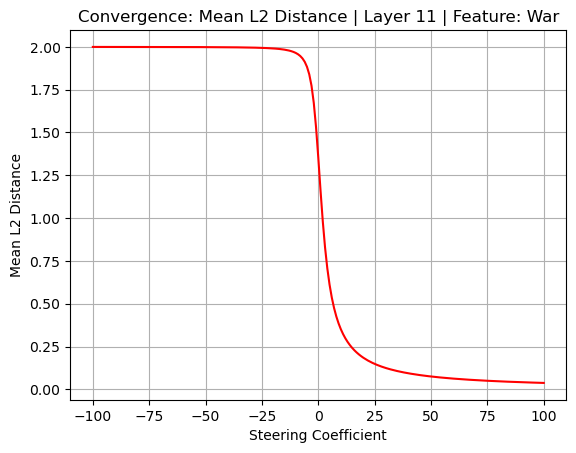

Distance at coefficient 0: 1.3538
Minimum distance: 0.0379 at coefficient ≈ 100.000
Maximum distance: 1.9996 at coefficient ≈ -100.000
Converged (negative side) around coefficient ≈ -19.000 | Distance: 1.9898
Converged (positive side) around coefficient ≈ 64.000 | Distance: 0.0591
Final distance: 0.0379 at coefficient = 100.000


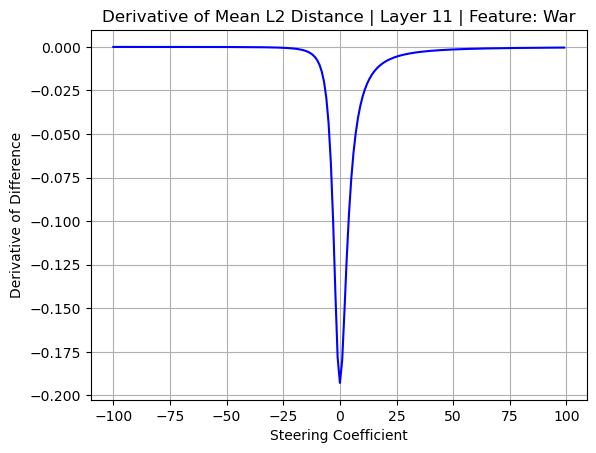

Effective region: coefficients ≈ [-15, 43]
Total change in effective region: 1.8961
90% of total change reached by coefficient ≈ 15


In [16]:
layer_to_steer = 11
feature = "War"

steering_vector = import_steering_vector_from_pkl('steering_vector.pkl', layer_to_steer=layer_to_steer, feature_name=feature)

convergence_check_with_vector(model, 
                              encoded_input,
                              layer_to_steer, 
                              steering_vector, 
                              feature, 
                              start_coeff=-100, 
                              end_coeff=100, 
                              normalize=True,
                              mode='l2', 
                              derivative=True, 
                              step_size=1,
                              grid=True, 
                              text_range=(0,100))

### Steering with a neuron

`convergence_check_with_neuron` plots the mean of the distance between the steered embeddings and a comparison vector (feature embedding) for a range of coefficients.

Steering vectors imported from steering_vector.pkl
Available steering vectors: 'Love' (layers: [11]), 'War' (layers: [10, 11])
Returning steering vector for 'War' layer 11
Processing convergence check...


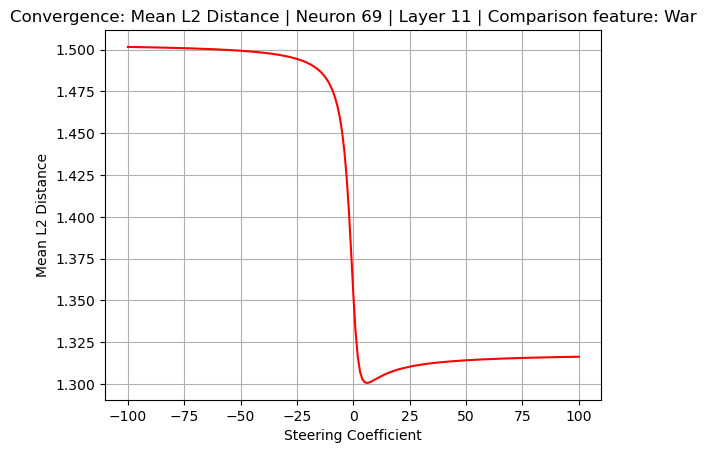

Distance at coefficient 0: 1.3538
Minimum distance: 1.3007 at coefficient ≈ 6.000
Maximum distance: 1.5016 at coefficient ≈ -100.000
Converged (negative side) around coefficient ≈ -16.000 | Distance: 1.4884
Converged (positive side) around coefficient ≈ 8.000 | Distance: 1.3015
Final distance: 1.3164 at coefficient = 100.000


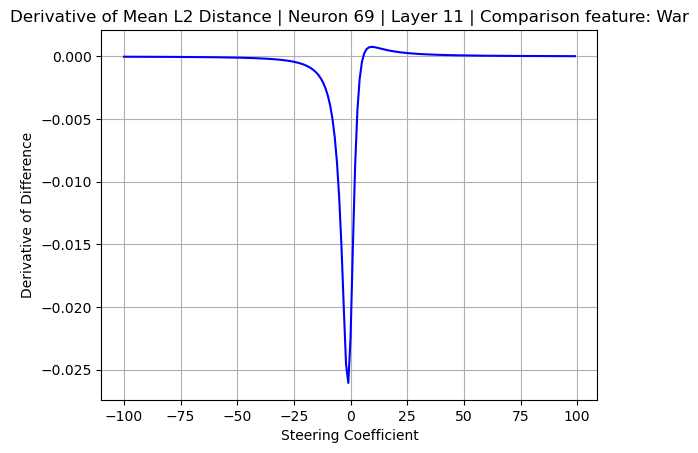

Effective region: coefficients ≈ [-12, 4]
Total change in effective region: 0.1797
90% of total change reached by coefficient ≈ 3


In [17]:
neuron = 69
layer_to_steer = 11
feature = "War"

comparison_vector = import_steering_vector_from_pkl('steering_vector.pkl', layer_to_steer=layer_to_steer, feature_name=feature)

convergence_check_with_neuron(model, 
                              encoded_input,
                              neuron,
                              layer_to_steer, 
                              comparison_vector, 
                              feature, 
                              start_coeff=-100, 
                              end_coeff=100, 
                              normalize=True,
                              mode='l2', 
                              derivative=True, 
                              step_size=1,
                              grid=True, 
                              text_range=(0,100))

## Convergence by category

`convergence_by_category` plots the mean distances from the steered embeddings to the steering vector, for each of the categories given, to see how they change individually. (Steering is done using a steering vector)

- `category_column (String)` chooses the column in the data frame to categorize by 
- `min_count (int)` removed the categories that don't have at least that amount of data points

The rest of the parameters are the same as the other convergence plots.  
 
The analysis printed at the end, are given for each category (min, max, positive and negative convergence point)

Steering vectors imported from steering_vector.pkl
Available steering vectors: 'Love' (layers: [11]), 'War' (layers: [10, 11])
Returning steering vector for 'War' layer 11
Processing convergence by category...


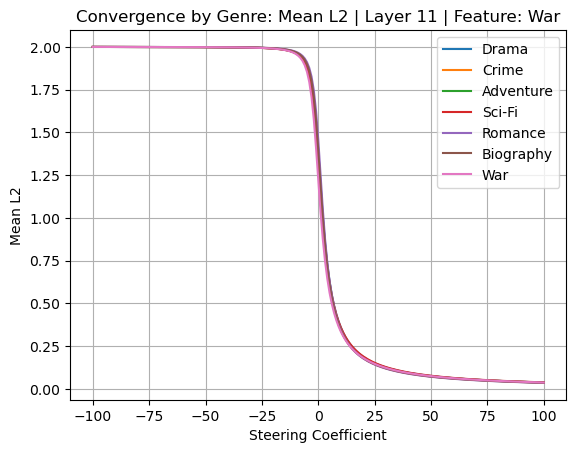


Convergence analysis by category (slope-based):

Drama:
 Minimum distance: 0.0383 at coefficient ≈ 100
 Maximum distance: 1.9996 at coefficient ≈ -100
 Converged (negative side) around coefficient ≈ -19 | Distance: 1.9898
 Converged (positive side) around coefficient ≈ 65 | Distance: 0.0588

Crime:
 Minimum distance: 0.0376 at coefficient ≈ 100
 Maximum distance: 1.9996 at coefficient ≈ -100
 Converged (negative side) around coefficient ≈ -20 | Distance: 1.9907
 Converged (positive side) around coefficient ≈ 64 | Distance: 0.0585

Adventure:
 Minimum distance: 0.0380 at coefficient ≈ 100
 Maximum distance: 1.9996 at coefficient ≈ -100
 Converged (negative side) around coefficient ≈ -20 | Distance: 1.9905
 Converged (positive side) around coefficient ≈ 64 | Distance: 0.0592

Sci-Fi:
 Minimum distance: 0.0390 at coefficient ≈ 100
 Maximum distance: 1.9996 at coefficient ≈ -100
 Converged (negative side) around coefficient ≈ -20 | Distance: 1.9902
 Converged (positive side) around coeffi

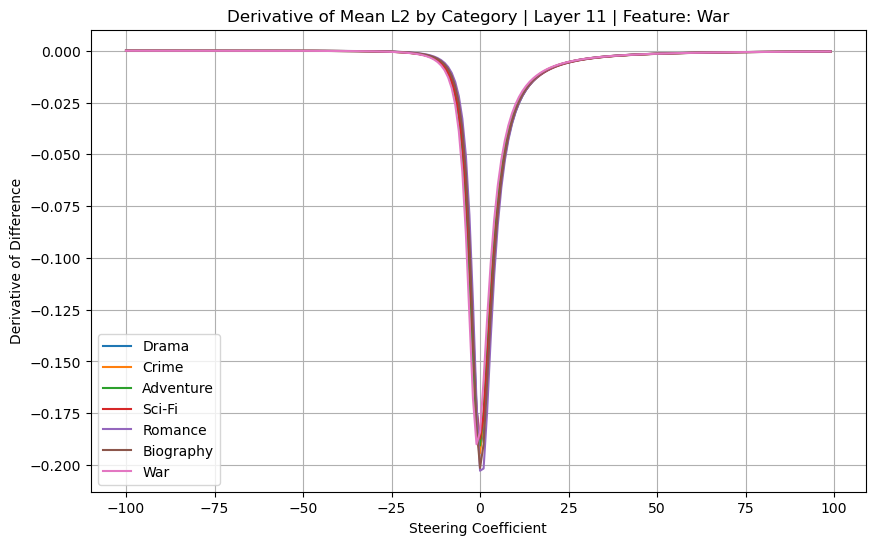

In [18]:
layer_to_steer = 11
feature = "War"

steering_vector = import_steering_vector_from_pkl('steering_vector.pkl', layer_to_steer=layer_to_steer, feature_name=feature)

convergence_by_category(model, 
                        encoded_input, 
                        all_texts_data, 
                        layer_to_steer, 
                        steering_vector, 
                        feature, 
                        category_column='genre', 
                        start_coeff=-100, 
                        end_coeff=100, 
                        normalize=True, 
                        mode='l2', 
                        derivative=True, 
                        step_size=1, 
                        grid=True, 
                        text_range=(0,100), 
                        min_count=5) 

***

# Neuron Activations for Categories

The following functions are imported from the file `"Activations_categories.py"`. They are necessary to analyze how individual neurons are activated in the model when performing steering using a steering vector.

In [19]:
#from Activations_categories import get_category_activations, plot_category_activations, find_activation_shift, create_neuron_shift_heatmap, plot_change_in_top_shifted_neurons

## Setup

Before we start analyzing we must prepare everything we need

In [20]:
# Import the necessasry data
data = import_embedding_data_from_pkl("Test_export_embeddings.pkl", model=True, model_output=True, encoded_input=True, all_texts_data=True)
model, model_output, encoded_input, all_texts_data = data

feature = "War"
category = "Action" # Choose what category to analyze, can be any category in the dataset
type = "cosine" # Chose what distance measure to use: l1, l2 or cosine
layer_to_steer = 10  # Change this to the layer you want to analyze, can not be the last layer. Steering in the next to last layer
# will affect the activations of neurons in the last layer.
layer_to_plot = 11  # Choose what layer to plot the category activations from

steering_coefficient = 10  # Adjust steering coefficient as needed

steering_vector = import_steering_vector_from_pkl('steering_vector.pkl', feature_name=feature, layer_to_steer=layer_to_steer)

Importing 1.36 GB data from file Test_export_embeddings.pkl...
Data imported from Test_export_embeddings.pkl
Model loaded successfully.
Model output loaded successfully.
Encoded input loaded successfully.
All texts data loaded successfully.
Steering vectors imported from steering_vector.pkl
Available steering vectors: 'Love' (layers: [11]), 'War' (layers: [10, 11])
Returning steering vector for 'War' layer 10


After the Setup we have:
- model, model_output, original_embeddings, encoded_input, all_texts_data
- feature
- category
- type
- layer_to_steer, layer_to_plot
- steering_coefficient
- steering_vector

## Analysis

### <a id="get-category-activations"></a>Get Category Activations

`get_category_activations` calculates the activations for each neuron in a specific layer for a category.
- `layer_to_plot` is a layer that comes after the layer that was steered. This is because you will not see the effect on the activations of the neurons in the same layer that you apply the steering.

In [21]:
# Get the category activations for the original model output
original_category_activations = get_category_activations(model_output, encoded_input, all_texts_data, layer_index=layer_to_plot)

# Create the steered model output
steered_model_output = create_steered_model_output(
    model, 
    encoded_input, 
    layer_to_steer=layer_to_steer, 
    steering_coefficient=steering_coefficient, 
    steering_vector=steering_vector
    )
# Get the category activations for the steered model output
steered_category_activations = get_category_activations(steered_model_output, encoded_input, all_texts_data, layer_index=layer_to_plot)

Created steered model output with shape: torch.Size([1000, 66, 384])


### <a id="plot-category-activations"></a>Plot Category Activations

`plot_category_activations` plots the activation values (y-axis) and the neuron index (x-axis) that was calculated from `get_category_activations`
- `original_category_activations` are the original activation values for the neurons retrieved from `get_category_activations`
- `steered_category_activations` are the steered acitvation values for the neurons retrieved from `get_category_activations`
- `category` is what category to retrive the activations for.
- `info_string` is what will be displayed in the title of the plot to keep track of the selected parameters for that plot.

In [22]:
# Plot the category activations for the original model output
info_string = f'Category Activations for {category} | Count: {len(all_texts_data[all_texts_data["genre"] == category])} | Layer: {layer_to_plot}'
plot_category_activations(original_category_activations, category, info_string)

In [23]:
# Plot the category activations for the steered model output
info_string = f'Category Activations for {category} | Count: {len(all_texts_data[all_texts_data["genre"] == category])} | Layer: {layer_to_plot} | Steering Coefficient: {steering_coefficient} | Steered layer: {layer_to_steer}'
plot_category_activations(steered_category_activations, category, info_string)

### <a id="find-activation-shift"></a>Find Activation Shift

Now, we will look at how the activations of neurons shift from the original to the steered acitvations using the "find_activation_shift" function. The function can also create a heatmap of the top shifted neurons across categories, if the categories parameter is None

`find_activation_shift` creates a printed table of the top shifted neurons (i.e. the neurons that changed the most in activatino value between the steered and original activation).
- `original_category_activations` are the original activation values for the neurons retrieved from `get_category_activations`
- `steered_category_activations` are the steered acitvation values for the neurons retrieved from `get_category_activations`

In [24]:
# Example of usage without heatmap for a single category
find_activation_shift(original_category_activations, steered_category_activations, category=category, top_n=5);


Printing top 5 most shifted neurons for category: Action

Category: Action
Neuron   Original    Steered      Shift
----------------------------------------
    69    -0.0264     1.9208    +1.9472
   270     0.1543     1.9610    +1.8068
   137     0.3166     1.9531    +1.6365
   173    -0.0569    -1.5309    -1.4740
   189    -0.0643    -1.5204    -1.4561


### <a id="create-neuron-shift-heatmap"></a>Create Heatmap

`create_neuron_shift_heatmap` will create a heatmap of the neurons that shifted the most across all categories. This helps identify both global and local activations, the heatmap only includes categories with more than 25 titles.
- `neuron_shifts` are the shifts calculated from `find_activation_shift`
- `all_texts_data` is the dataframe containing all information about the titles, but at least `title`, `genre` and `ovweview`.
- `info_string` is what will be displayed in the title of the plot to keep track of the selected parameters for that plot.
- `top_n` is how many neurons to have in the heatmap


Printing top 5 most shifted neurons for each category:

Category: Drama
Neuron   Original    Steered      Shift
----------------------------------------
    69    -0.0441     1.9031    +1.9472
   270     0.0559     1.8627    +1.8068
   137     0.1343     1.7708    +1.6365
   173     0.1652    -1.3088    -1.4740
   189     0.0861    -1.3700    -1.4561

Category: Crime
Neuron   Original    Steered      Shift
----------------------------------------
    69    -0.0141     1.9331    +1.9472
   270     0.0931     1.8999    +1.8068
   137     0.3432     1.9797    +1.6365
   173     0.0492    -1.4247    -1.4740
   189     0.1721    -1.2840    -1.4561

Category: Adventure
Neuron   Original    Steered      Shift
----------------------------------------
    69    -0.1397     1.8075    +1.9472
   270     0.0646     1.8714    +1.8068
   137     0.2042     1.8406    +1.6365
   173     0.0768    -1.3971    -1.4740
   189     0.0638    -1.3923    -1.4561

Category: History
Neuron   Original    Steere

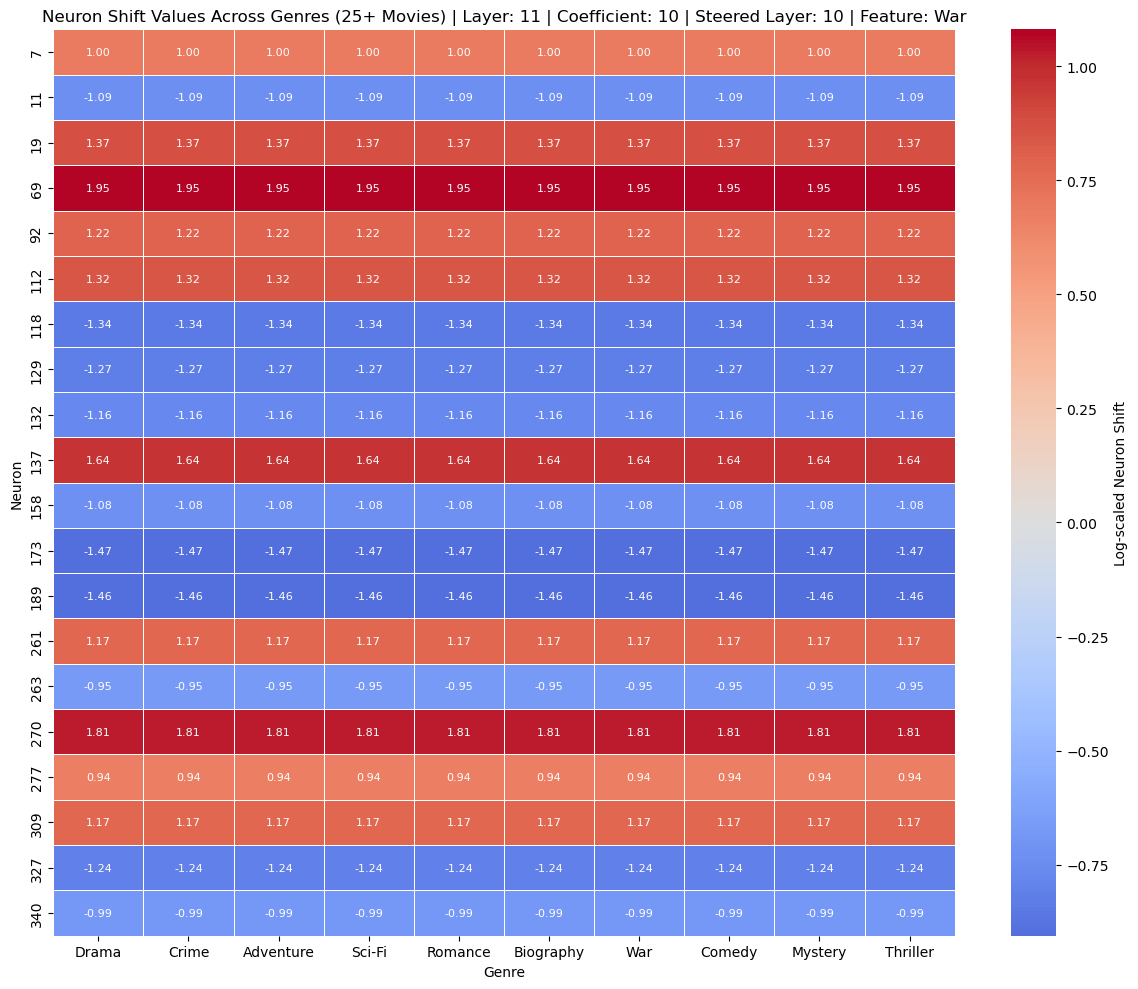

In [25]:
# Example of usage with heatmap for all categories
# Get the neuron_shifts for all categories
neuron_shifts = find_activation_shift(original_category_activations, steered_category_activations, top_n=5)
# Create a heatmap of the top shifted neurons across categories
info_string = f"Neuron Shift Values Across Genres (25+ Movies) | Layer: {layer_to_plot} | Coefficient: {steering_coefficient} | Steered Layer: {layer_to_steer} | Feature: {feature}"
create_neuron_shift_heatmap(neuron_shifts, all_texts_data, info_string=info_string, top_n=20)

### <a id="plot-change-in-top-shifted-neurons"></a>Plot Change in Top Shifted Neurons

The following function allows us to plot the change in activation for the neurons that were most activated to begin with, as well as those that had the highest shift after the steering was completed.

`plot_change_in_top_shifted_neurons` plots the activation for the neurons that were the most activated to begin with, as well as those that had the highest shift after the steering was completed (steering_coefficient, activation_value)
- `all_texts_data` is the dataframe containing all information about the titles, but at least `title`, `genre` and `ovweview`.
- `layer_to_plot` is a layer that comes after the layer that was steered. This is because you will not see the effect on the activations of the neurons in the same layer that you apply the steering.
- `layer_to_steer` is what layer to perform steering on
- `category` is what category to analyze activations for
- `steering_coefficient_start` is the first steering coefficient (i.e. the beginning of the x-axis)
- `steering_coefficient_end` is the last steering coefficient (i.e. the end of the x-axis)
- `info_string` is what will be displayed in the title of the plot to keep track of the selected parameters for that plot.
- `number_of_steps` are the number of points for which to do the analysis (i.e. the number of steering coefficients to analyze from start to end)
- `number_of_neurons` is the maximum amount of neurons to analyze (if there is an overlap between most shifted and most activated there will be fewer neurons)

In [26]:
info_string = f'Individual Neuron Trajectories | {category} | Displayed Layer: {layer_to_plot} | Feature: {feature} | Steered Layer: {layer_to_steer}'
plot_change_in_top_shifted_neurons(
    model,
    model_output,
    encoded_input, 
    all_texts_data,
    layer_to_plot,
    layer_to_steer, 
    category, 
    steering_coefficient_start=0.0, 
    steering_coefficient_end=6,
    steering_vector=steering_vector,
    info_string=info_string,
    number_of_steps=10, 
    number_of_neurons=10);


Analyzing category: Action
Identifying neurons to track...
Created steered model output with shape: torch.Size([1000, 66, 384])
Reference coefficient for shift calculation: 6.000
Most activated neurons identified from original (unsteered) activations

Tracking 10 neurons in category 'Action':
1. Most Shifted: Neuron 69 (Shift: 1.1683, Original: -0.0264)
2. Most Shifted: Neuron 270 (Shift: 1.0841, Original: 0.1543)
3. Most Shifted: Neuron 137 (Shift: 0.9819, Original: 0.3166)
4. Most Shifted: Neuron 173 (Shift: 0.8844, Original: -0.0569)
5. Most Shifted: Neuron 189 (Shift: 0.8736, Original: -0.0643)
6. Most Activated: Neuron 223 (Shift: 0.0110, Original: -2.2563)
7. Most Activated: Neuron 99 (Shift: 0.3654, Original: 0.7897)
8. Most Activated: Neuron 363 (Shift: 0.3550, Original: 0.6942)
9. Most Activated: Neuron 157 (Shift: 0.3408, Original: 0.6488)
10. Most Activated: Neuron 249 (Shift: 0.2006, Original: 0.6164)

Analyzing trajectories across 10 steering coefficients from 0.0 to 6
Pro

***

# Neuron Activations for Tokens and Texts

The following functions are imported from the file `"Activations_tokens_and_texts.py"`. They are necessary to analyze how individual neurons are activated in the model when performing steering using a steering vector for individual tokens and texts.

In [27]:
#from Activations_tokens_and_texts import get_text_activations_per_layer, plot_text_activations_per_layer, compare_text_activations, find_extreme_nodes_for_all_texts, plot_extreme_nodes_for_all_texts

## Setup

Before we start analyzing we must prepare everything we need

In [28]:
# Import data from pkl file
data = import_embedding_data_from_pkl(
    "Test_export_embeddings.pkl",
    model=True, 
    tokenizer=True, 
    encoded_input=True, 
    hidden_states=True, 
    all_texts_data=True)

model, tokenizer, encoded_input, hidden_states, all_texts_data = data  # Unpack in the order they were requested
texts = all_texts_data['overview'].tolist()[:100]  # Use the overview column for text data and choose how many texts to analyze

feature = "War"
layer_to_steer = 10 # Can not be last layer, should be next to last layer
steering_coefficient = 10
steering_vector = import_steering_vector_from_pkl('steering_vector.pkl', feature, layer_to_steer=layer_to_steer)

steered_model_output = create_steered_model_output(model, encoded_input, layer_to_steer, steering_coefficient, steering_vector, verbose=False)
steered_hidden_states = steered_model_output.hidden_states

Importing 1.36 GB data from file Test_export_embeddings.pkl...
Data imported from Test_export_embeddings.pkl
Model loaded successfully.
Tokenizer loaded successfully.
Encoded input loaded successfully.
Hidden states loaded successfully.
All texts data loaded successfully.
Steering vectors imported from steering_vector.pkl
Available steering vectors: 'Love' (layers: [11]), 'War' (layers: [10, 11])
Returning steering vector for 'War' layer 10


After the Setup we have:
- tokenizer, encoded_input, hidden_states, all_texts_data
- texst
- feature
- layer_to_steer
- steering_coefficient
- steering_vector
- steered_model_output
- steered_hidden_states

### Get Text Activations

`get_text_activations_per_layer` retrives the neuron activations for all texts for all layers and returns them as a list

In [29]:
text_activations = get_text_activations_per_layer(hidden_states, encoded_input['attention_mask'])

# Also create steered text activations
steered_text_activations = get_text_activations_per_layer(steered_hidden_states, encoded_input['attention_mask'])

### Plot Text Activations

`plot_text_activations_per_layer` creates a plot of the activatinos from `get_text_activations_per_layer`
-  `text_activations` is the list of activation values from `get_text_activations_per_layer`
- `layers` are what layers do display. Can be either `None`, `int`, `tuple` or `list` for all, one or multiple layers to be displayed
- `text_index` is what text index to plot the activation values for

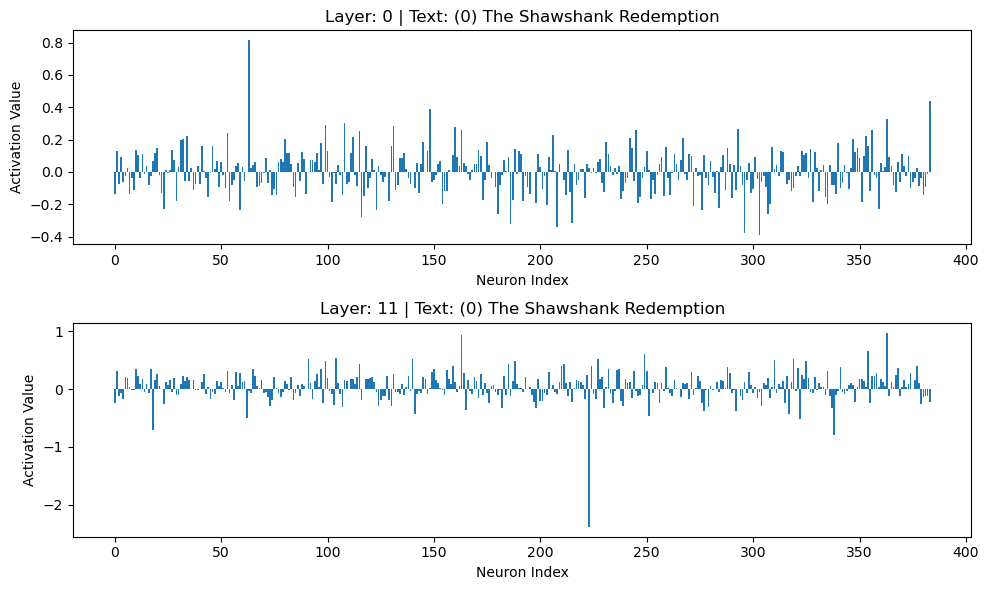


Extreme nodes for text (0) The Shawshank Redemption across selected layers:
 Layer   Min Node   Max Node
----------------------------
     0        303         63
    11        223        363



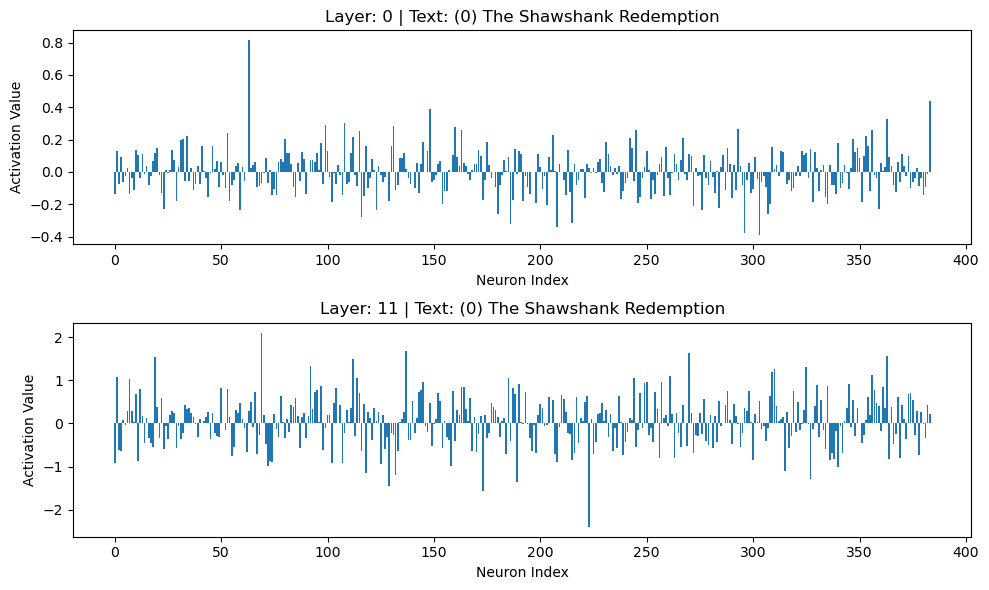


Extreme nodes for text (0) The Shawshank Redemption across selected layers:
 Layer   Min Node   Max Node
----------------------------
     0        303         63
    11        223         69



In [30]:
text_index = 0  # Index of the text to plot activations for
info_string = f'Text Activations for "{texts[text_index]}"'

plot_text_activations_per_layer(text_activations, all_texts_data, layers=(0, 11), text_index=text_index)

plot_text_activations_per_layer(steered_text_activations, all_texts_data, layers=(0, 11), text_index=text_index)

### Compare Text Activations

`compare_text_activations` plots two text activation plots on top of each other for comparison
- `text_activations` is the list of activation values from `get_text_activations_per_layer`
- `text_indices` are the indexes of the two texts you want to compare (text_index_1, text_index_2)
- `layers` are what layers do display. Can be either `None`, `int`, `tuple` or `list` for all, one or multiple layers to be displaye

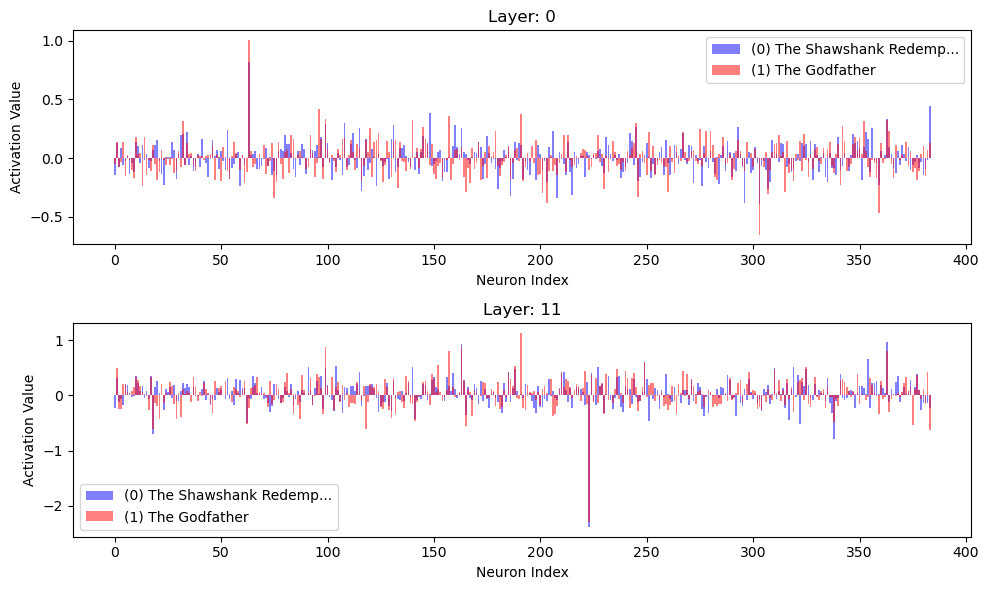


Extreme nodes comparison for texts (0) The Shawshank Redemption and (1) The Godfather:
 Layer T0 Min T0 Max T1 Min T1 Max
----------------------------------------
     0      303       63      303       63
    11      223      363      223      191



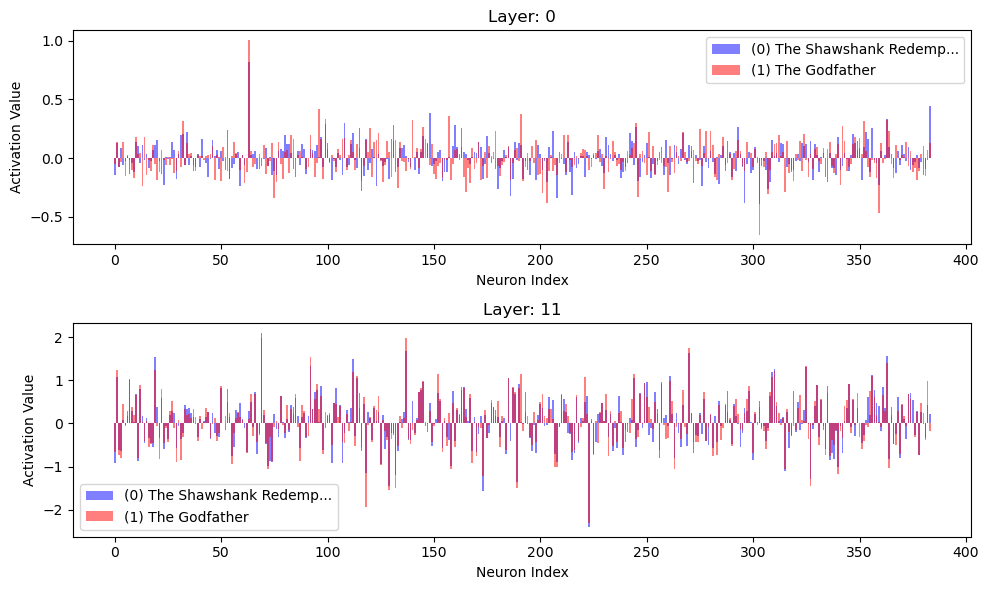


Extreme nodes comparison for texts (0) The Shawshank Redemption and (1) The Godfather:
 Layer T0 Min T0 Max T1 Min T1 Max
----------------------------------------
     0      303       63      303       63
    11      223       69      223      137



In [31]:
compare_text_activations(text_activations, all_texts_data, text_indices=(0, 1), layers=(0, 11))  # Compare activations for the first two texts

# Also compare the steered text activations
compare_text_activations(steered_text_activations, all_texts_data, text_indices=(0, 1), layers=(0, 11))

### Find Extreme Nodes

`find_extreme_nodes` returns the most and least activated neurons for all texts
- `layer` is what layer to find the extreme neurons for

In [32]:
min_nodes, max_nodes = find_extreme_nodes_for_all_texts(texts, text_activations, all_texts_data, layer=11)  # Find extreme nodes for all texts in layer 11
steered_min_nodes, steered_max_nodes = find_extreme_nodes_for_all_texts(texts, steered_text_activations, all_texts_data, layer=11);  # Find extreme nodes for all texts in steered layer 11


Extreme nodes for all texts in Layer 11:
                                              Text   Min Node   Max Node
------------------------------------------------------------------------
                      (0) The Shawshank Redemption        223        363
                                 (1) The Godfather        223        191
                               (2) The Dark Knight        223        319
                        (3) The Godfather: Part II        223        319
                                  (4) 12 Angry Men        223        363
        (5) The Lord of the Rings: The Return o...        223         99
                                  (6) Pulp Fiction        223        329
                              (7) Schindler's List        223         99
                                     (8) Inception        223         99
                                    (9) Fight Club        223         99
       (10) The Lord of the Rings: The Fellowsh...        223         99
         

### Plot Extreme Nodes

`plot_extreme_nodes_for_all_texts` plots the neurons we found in `find_extreme_nodes_for_all_texts` with (neuron index, text index)
- `min_nodes` is a list of the indexes of the least activated neurons, retrieved from `find_extreme_nodes_for_all_texts`
- `max_nodes` is a list of the indexes of the most activated neurons, retrieved from `find_extreme_nodes_for_all_texts`

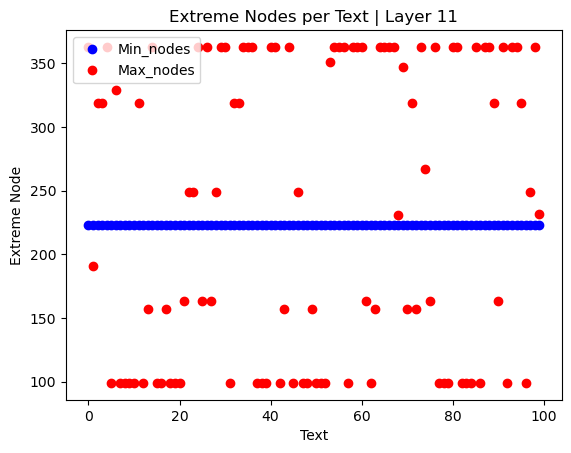

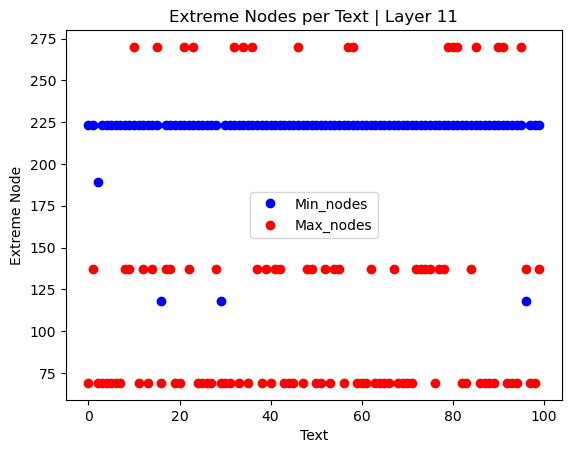

In [33]:
plot_extreme_nodes_for_all_texts(min_nodes, max_nodes, layer=11)  # Plot extreme nodes for all texts in layer 11
plot_extreme_nodes_for_all_texts(steered_min_nodes, steered_max_nodes, layer=11)  # Plot extreme nodes for all texts in steered layer 11